In [6]:
import numpy as np
import pandas as pd
import matplotlib as plt
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [7]:
ticker = 'AAPL'
daysago = 10

ticker = yf.Ticker(ticker.upper())
df = ticker.history(period='max')
df = df[['Close']]
    

for i in range(daysago,-1,-1):
    df['{}daysago'.format(i)] = df['Close'].shift(i)
    df = df.copy()


bruh = pd.DataFrame()
# bruh['-1daysago'.format(i)] = df['Close'].shift(-1)
bruh['pct'] = df['{}daysago'.format(daysago)].pct_change().shift(-1) * 100

df = df.drop(['Close'], axis=1)


df,bruh = df.dropna(),bruh.dropna()
df = df.drop(df.head(1).index)
sc = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))


X,Y = sc.fit_transform(df), sc.fit_transform(bruh)


split = int(len(X)*0.99)
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,1)), Y_test.reshape((-1,1))
X.shape,Y.shape   

((10978, 11), (10978, 1))

In [8]:
def DataPrep(ticker='aapl',daysago=10):
    ticker = yf.Ticker(ticker.upper())
    df = ticker.history(period='max')
    df = df[['Close']]
        

    for i in range(daysago,-1-1,-1):
        df['{}daysago'.format(i)] = df['Close'].pct_change(1).shift(i)
        df = df.copy()


    bruh = pd.DataFrame()
    # bruh['-1daysago'.format(i)] = df['Close'].shift(-1)
    # bruh['pct'] = df['{}daysago'.format(daysago)].pct_change().shift(-1) * 100

    df = df.drop(['Close'], axis=1)


    df,bruh = df.dropna(),bruh.dropna()
    # df = df.drop(df.head(1).index)
    sc = MinMaxScaler(feature_range=(0,1))
    sc2 = MinMaxScaler(feature_range=(0,1))


    scaled = sc.fit_transform(df)#, sc.fit_transform(bruh)
    X,Y = scaled[:,:daysago+1], scaled[:,daysago+1:]

    split = int(len(X)*0.99)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,1)), Y_test.reshape((-1,1))

    return X_train, X_test, Y_train, Y_test,



In [9]:
sp500list = pd.read_csv("../4th attempt total/SP500.csv")
ListOfTickers = []
for i in sp500list['Symbol']:
    ListOfTickers.append(i)

ListOfTickers.remove('BRK.B')
ListOfTickers.remove('BF.B')
ListOfTickers.remove('GEV')
ListOfTickers.remove('SOLV')
ListOfTickers.remove('HUBB')




In [10]:
sp500 = DataPrep('^gspc',10)
sp500_X_test, sp500_Y_test = sp500[1], sp500[3]

model2 = Sequential()
model2.add(InputLayer((11, 1)))
model2.add(LSTM(11))
model2.add(Dense(11, 'softmax'))
model2.add(Dense(1, 'linear'))


#no more training 5th, skidaddle from here
cp1 = ModelCheckpoint('../model/5th.keras', save_best_only=False)

model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

for ticker in ListOfTickers:
    Data = DataPrep(ticker,10)
    X_train, Y_train = Data[0], Data[2]
    sp500_X_test = np.concatenate((sp500_X_test,Data[1]))
    sp500_Y_test = np.concatenate((sp500_Y_test,Data[3]))
    
    print(ticker)
    model2.fit(X_train, Y_train, epochs=2, batch_size=128, callbacks=[cp1])

# model2.fit(X_train, Y_train, epochs=10, batch_size=128, callbacks=[cp1])

MMM
Epoch 1/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1972 - root_mean_squared_error: 0.4395
Epoch 2/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502
AOS
Epoch 1/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276 - root_mean_squared_error: 0.1612
Epoch 2/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517
ABT
Epoch 1/2
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1072
Epoch 2/2
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563
ABBV
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0579
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573
ACN
Epoch 1/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - root_mean_squared_error: 0.0885
Epoch 2/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.

In [13]:
model2 = load_model('../model/5th.keras')
y_pred = model2.predict(sp500_X_test)
# y_pred = y_pred.reshape(-1,2,1)
avg_error = (np.sum(np.sqrt((sp500_Y_test - y_pred)**2)))/len(sp500_Y_test)*100

print(avg_error)
avg_error = (np.sum(y_pred - sp500_Y_test))/len(sp500_Y_test)*100
print(avg_error)

1325/1325 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step
6.457255855681894
3.188985136672661


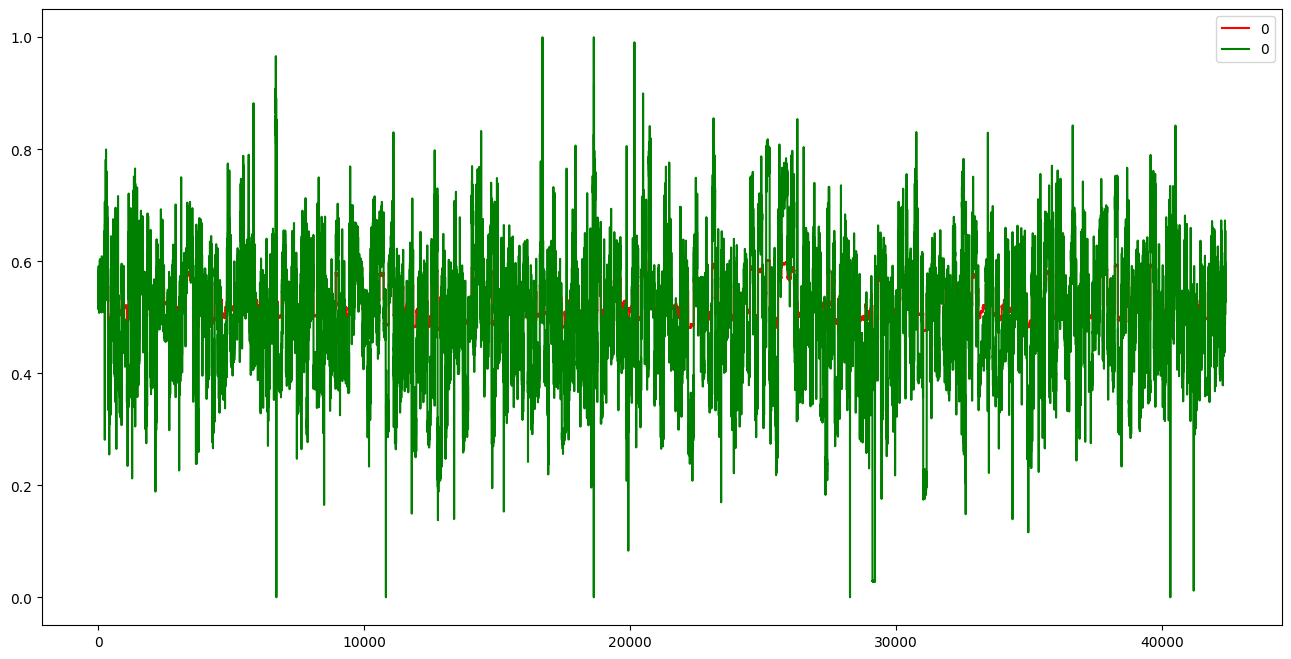

In [14]:
# y_pred,sp500_Y_test = y_pred.reshape(-1,2),sp500_Y_test.reshape(-1,2)
y_pred,sp500_Y_test = pd.DataFrame(y_pred),pd.DataFrame(sp500_Y_test)
for i in range(0,y_pred.shape[1]): 
    oneday= pd.concat([y_pred[i],sp500_Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('red','green'))
    
    